In [9]:
import numpy as np

from typing import Tuple


def conv2d(a, f):
    s = f.shape + tuple(np.subtract(a.shape, f.shape) + 1)
    strd = np.lib.stride_tricks.as_strided
    subM = strd(a, shape=s, strides=a.strides * 2)
    return np.einsum("ij,ijkl->kl", f, subM)


def gaussian_blur(img: np.ndarray, kernel: Tuple[int, int], sigma: float) -> np.ndarray:
    """Blurs an image using Gaussian filter.

    Arguments:
        img: input image, a 2d np.ndarray.
        kernel: gaussian kernel size.
        sigma: gaussian kernel standard deviation.

    Returns:
        Blurred image, a 2d np.ndarray of the same size and dtype as `img`.
    """

    offset_y = int((kernel[0] - 1) / 2)
    offset_x = int((kernel[1] - 1) / 2)
    y, x = (
        np.arange(kernel[0]) - offset_y,
        np.arange(kernel[1]) - offset_x,
    )
    kernel_cords = np.concatenate([t[..., None] for t in np.meshgrid(y, x)], axis=-1)

    kernel = np.exp(-np.power(kernel_cords, 2).sum(axis=-1) / (2 * sigma * sigma)) / (
        2 * np.pi * sigma * sigma
    )
    kernel = kernel / kernel.sum()

    img = np.pad(img, (offset_y, offset_x), mode="reflect")
    return conv2d(img, kernel).astype(int)


def magnitude_and_direction(
    img: np.ndarray, kernel: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """Applies a filter to the image and computes magnitude and direction of the gradient.
    The filter is applied using 'reflect' mode for border pixels, i.e. dcb|abcd|cba

    Arguments:
        img: input image, a 2d np.ndarray.
        kernel: the filter kernel, a 2d np.ndarray with odd dimension sizes.
            The kernel is applied over x dimension, kernel.T is applied over y

    Returns:
        Magnitude and direction of the gradient, two 2d np.ndarray objects of the same size and dtype as `img`.
        The direction values lie in range [0, 2 * pi].
    """
    offset_y = int((kernel.shape[0] - 1) / 2)
    offset_x = int((kernel.shape[1] - 1) / 2)

    img = np.pad(img, (offset_y, offset_x), mode="reflect")
    img_x = conv2d(img, kernel)
    img_y = conv2d(img, kernel.T)

    mag = np.sqrt(np.power(img_x, 2) + np.power(img_y, 2))
    dir = np.arctan2(img_x, img_y) + np.pi
    return mag, dir


def edge_thinning(magnitude: np.ndarray, direction: np.ndarray) -> np.ndarray:
    """Performs edge thinning step of Canny algorithm using 0°, 45°, 90°, 135°, 180° (=0°) gradient direction
    as described here https://en.wikipedia.org/wiki/Canny_edge_detector#Gradient_magnitude_thresholding_or_lower_bound_cut-off_suppression.
    If the angle is equally close to two groups, the group with lower angle value is selected.

    Arguments:
        magnitude: magnitude of image gradient, a 2d np.ndarray.
        direction: direction of image gradient, a 2d np.ndarray.

    Returns:
        Boolean mask of suppressed pixels (False if a pixel is suppresed, True if preserved), a 2d np.ndarray of the same size as `magnitude` and dtype bool.
    """

    magnitude = np.pad(magnitude, pad_width=1, mode="reflect")

    direction = direction - np.pi
    direction = (direction >= 0) * direction + (direction < 0) * (np.pi - direction)

    ang = np.pi / 8

    mask = (
        # Horizontal
        ((direction <= ang) | (direction > ang * 7))
        * np.maximum(magnitude[:-2, 1:-1], magnitude[2:, 1:-1])
        + ((direction > ang) & (direction <= ang * 3))
        * np.maximum(magnitude[:-2, :-2], magnitude[2:, 2:])
        + ((direction > ang * 3) & (direction <= ang * 5))
        * np.maximum(magnitude[1:-1, :-2], magnitude[1:-1, 2:])
        + ((direction > ang * 5) & (direction <= ang * 7))
        * np.maximum(magnitude[:-2, 2:], magnitude[2:, :-2])
    )

    mask = magnitude[1:-1, 1:-1] >= mask

    return mask


def edge_tracking(
    magnitude: np.ndarray, mask: np.ndarray, low_threshold: float, high_threshold: float
) -> np.ndarray:
    """Performs edge tracking step of Canny algorithm. The thresholds are inclusive.

    Arguments:
        magnitude: magnitude of image gradient, a 2d np.ndarray.
        mask: pixel suppression mask, obtained by edge_thinning function.
        low_threshold: weak pixel threshold.
        high_threshold: strong pixel threshold.

    Returns:
        A 2d np.ndarray of the same size as `magnitude` and dtype bool, representing detected edges.
    """
    edges = mask * magnitude
    strong = edges >= high_threshold
    weak = (edges > low_threshold) & (edges < high_threshold)
    road = np.zeros_like(edges, dtype=bool)
    temp = road.copy()
    for i in range(len(edges)):
        for j in range(len(edges[i])):
            if weak[i, j] == 0:
                continue
            if road[i, j]:
                continue
            t_map = temp.copy()
            points = [[i, j]]
            connected = False
            while len(points) > 0:
                t = points.pop()
                if t_map[t[0], t[1]]:
                    continue
                if strong[t[0], t[1]]:
                    connected = True
                    continue
                if weak[t[0], t[1]] == 0:
                    continue

                t_map[t[0], t[1]] = True

                points += [
                    [t[0] + 1, t[1]],
                    [t[0], t[1] + 1],
                    [t[0] - 1, t[1]],
                    [t[0], t[1] - 1],
                ]

            if connected:
                strong += t_map

    return strong

In [10]:
import cv2
import matplotlib.pyplot as plt

In [11]:
img = cv2.imread("cat.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(float)
blur = gaussian_blur(img, (5, 5), 1)
magnitude, direction = magnitude_and_direction(
    blur, np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
)
mask = edge_thinning(magnitude, direction)
edges = edge_tracking(magnitude, mask, 0.1 * np.max(magnitude), 0.2 * np.max(magnitude))
# cv2.imwrite("sample.png", edges.astype(int) * 255)

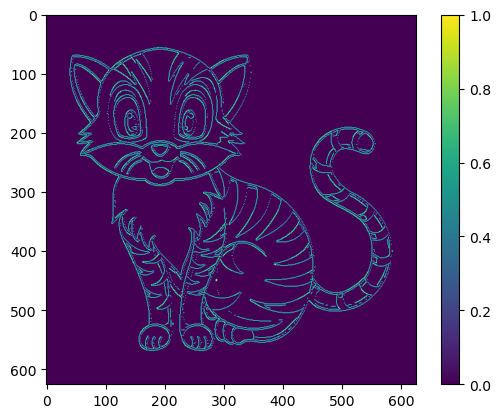

In [13]:
plt.imshow(edges)
plt.colorbar()